In [1]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json
import glob
import os

In [2]:
import struct
import socket
import binascii

def ip_to_int(ipv4_address):
    return struct.unpack('!I', socket.inet_aton(ipv4_address))[0]

def int_to_ip(ip_int):
   return socket.inet_ntoa(struct.pack('!I', ip_int))

def mask_to_int(mask):
    return int(binascii.hexlify(socket.inet_aton(mask)),16)

# function for reverse hexadecimal number
def reverse(string):
    # l for swap with index 2
    l = 2
    r = len(string) - 2

    # swap with in two-2 pair
    while l < r:
        string[l], string[r] = string[r], string[l]
        l += 1
        r -= 1
        string[l], string[r] = string[r], string[l]
        r -= 3

# function to conversion and print
# the hexadecimal value
def ipToHexa(addr):
    # convert integer to string for reverse
    # addr = int.from_bytes(socket.inet_aton(addr), 'big')
    # string = socket.inet_ntoa(addr.to_bytes(4, 'big'))
    string = addr
    string = '0x' + ''.join([format(int(x), '02x') for x in string.split('.')])

    # reverse for get actual hexadecimal
    # number without reverse it will
    # print 0x0100007f for 127.0.0.1
    string = list(string)
    # reverse(string)
    string = ''.join(string)

    # print string
    print(string)

In [3]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

../log/20250423_10-54-08_buf200000_GCsize100_GCperiod100_T1000000_stat.csv
   index      time  sample_at  pkt_process_time
0      1  0.000000       5000            3481.0
1      3  0.026419      10000             132.0
2      4  0.056013      15000               8.0
3      6  0.084163      20000              38.0
4      7  0.104664      25000              40.0
Empty DataFrame
Columns: [time, lazy_flow_clean_count, lazy_free_time]
Index: []


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

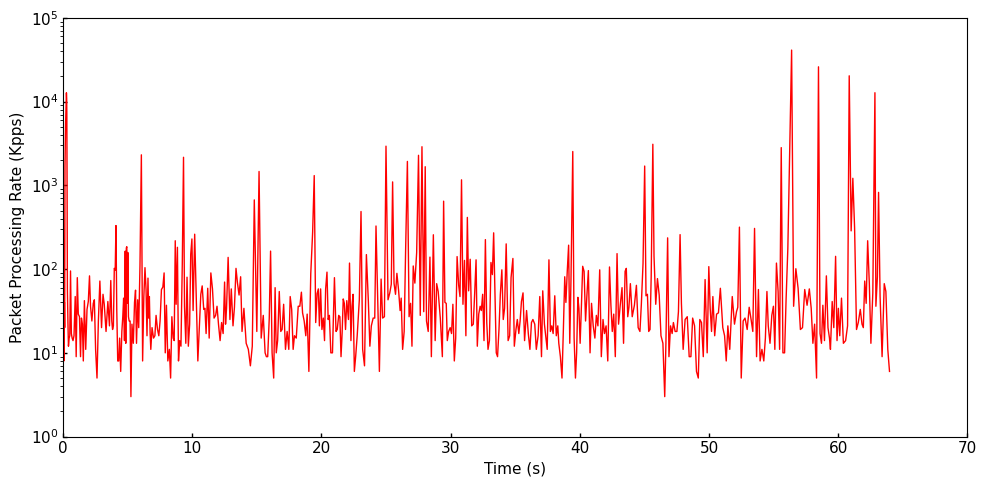

In [79]:
time_threshold = 1000
log_list = sorted(glob.glob("../log/*_stat.csv"), key=os.path.getmtime)
latest_log_file = log_list[-1]
print(latest_log_file)

raw_df = pd.read_csv(latest_log_file)
# raw_df['time'] = raw_df['time'] - raw_df['time'].min()
# raw_df = raw_df[raw_df['time'] < time_threshold]

stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df = stats_df.drop(columns=['level', 'file', 'line', 'msg'])
stats_df['time'] = stats_df['time'] - stats_df['time'].min()
stats_df.reset_index(inplace=True, drop=True)

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
pkt_process_time_df['time'] = pkt_process_time_df['time'] - pkt_process_time_df['time'].min()
pkt_process_time_df.reset_index(inplace=True)
print(pkt_process_time_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
timeout_df.reset_index(inplace=True, drop=True)

lazy_free_time_df = raw_df[raw_df['msg'] == 'lazy_flow_clean_count'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
lazy_free_time_df.columns = ['time', 'lazy_flow_clean_count', 'lazy_free_time']
lazy_free_time_df['time'] = lazy_free_time_df['time'] - lazy_free_time_df['time'].min()
lazy_free_time_df.reset_index(inplace=True, drop=True)
print(lazy_free_time_df.head())

fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              figsize=(10, 5), xlabel='Time (s)', 
              yscale='log',
              ylabel='Packet Processing Rate (Kpps)')

# Data Structure Usage

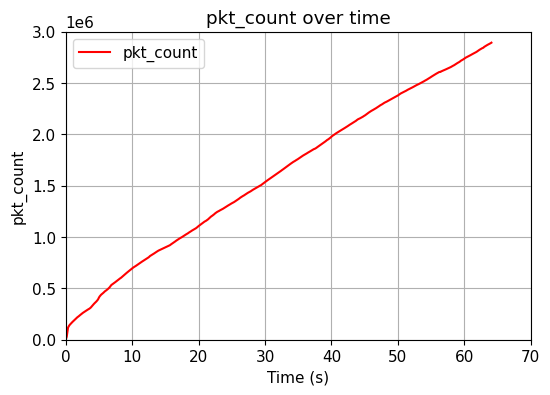

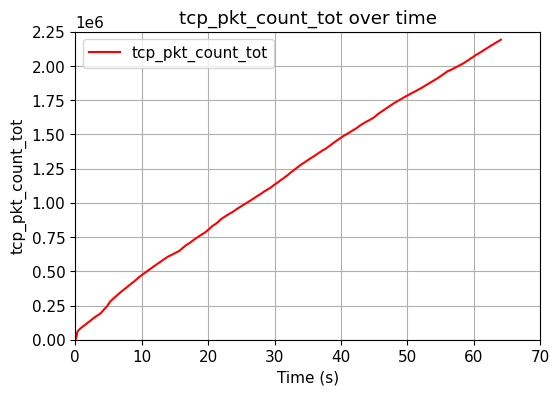

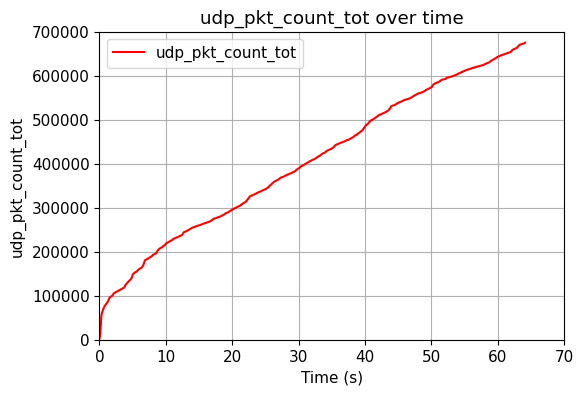

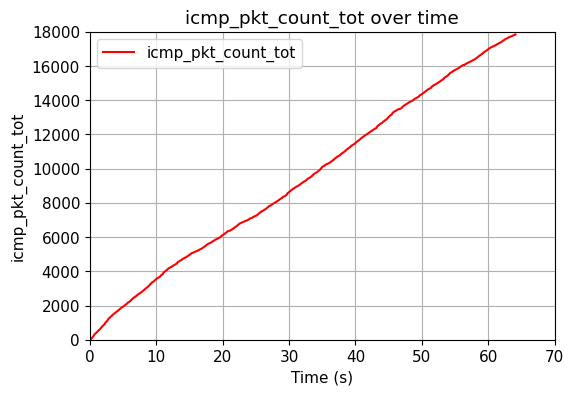

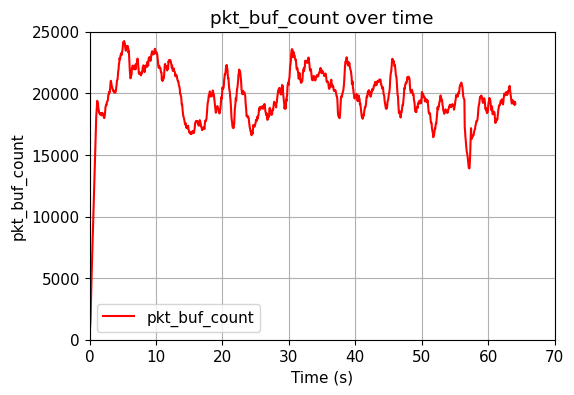

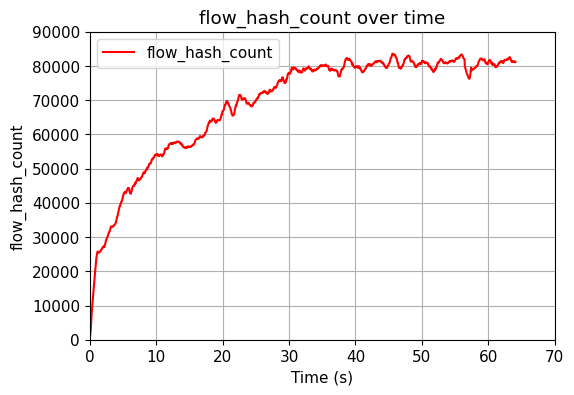

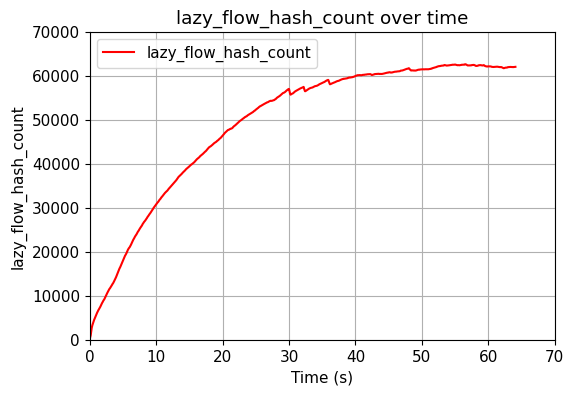

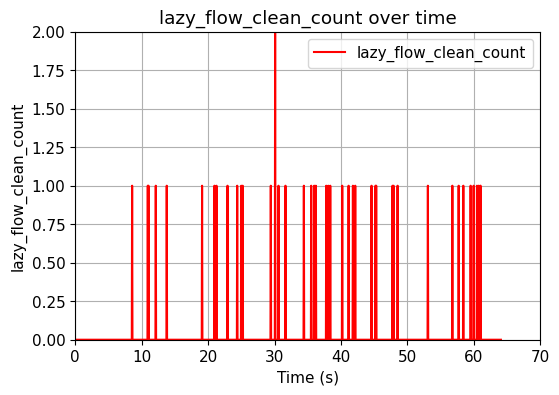

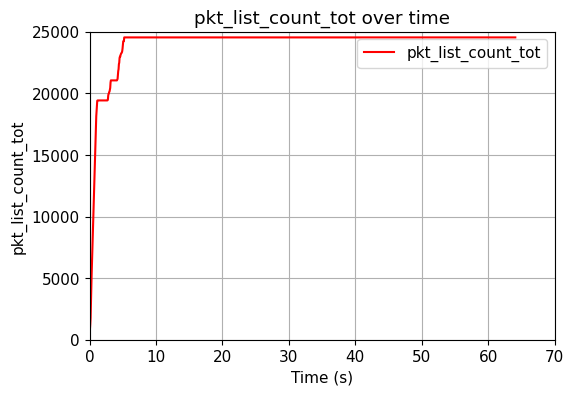

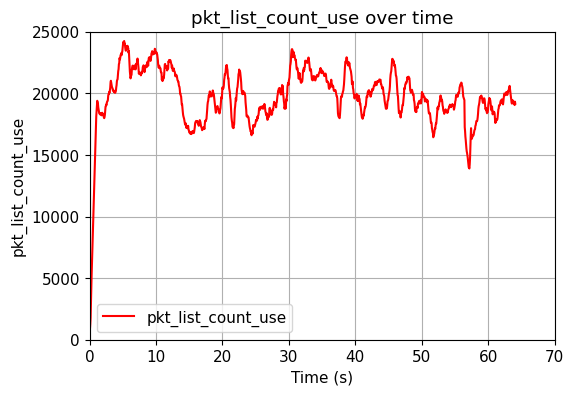

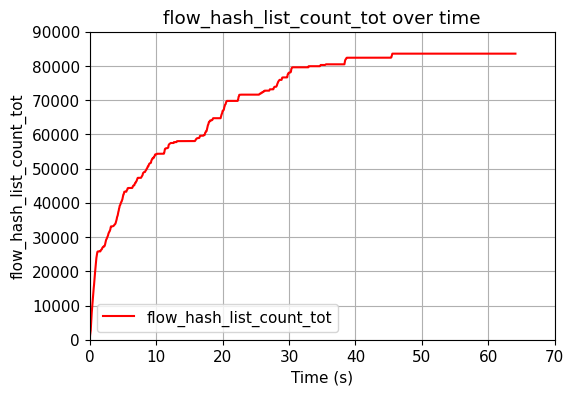

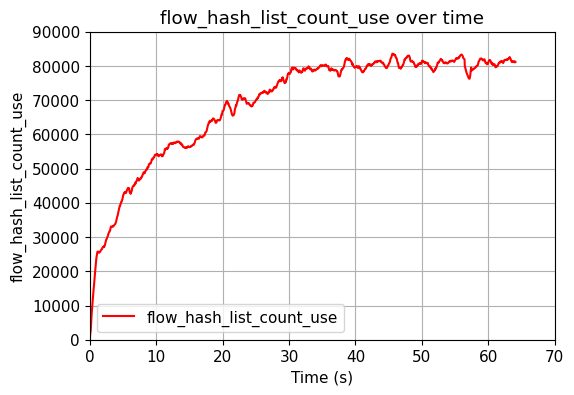

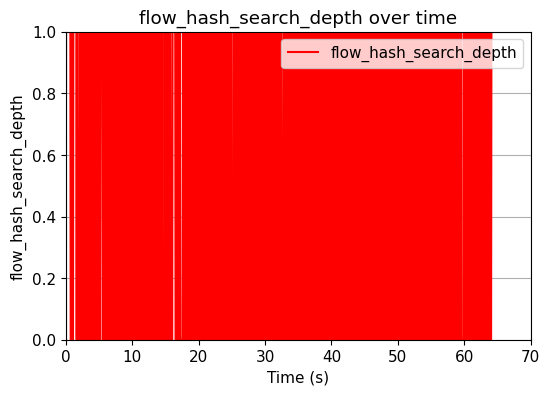

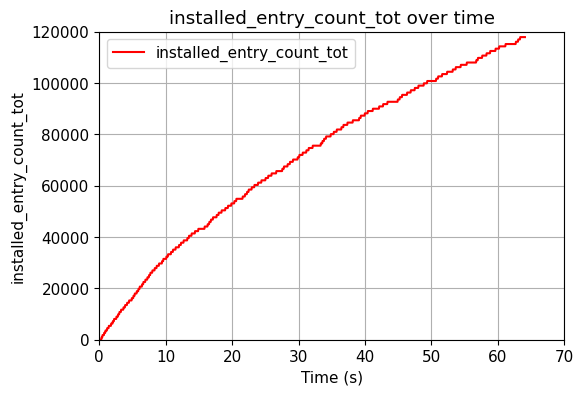

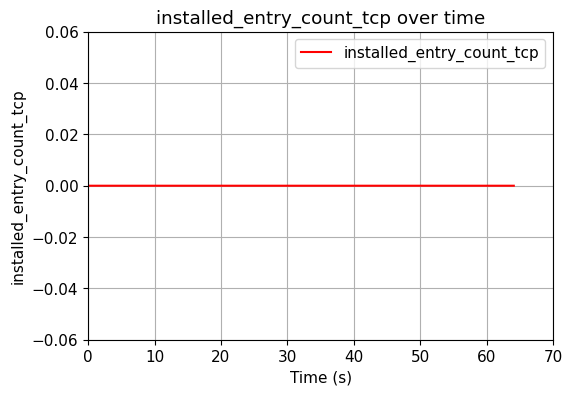

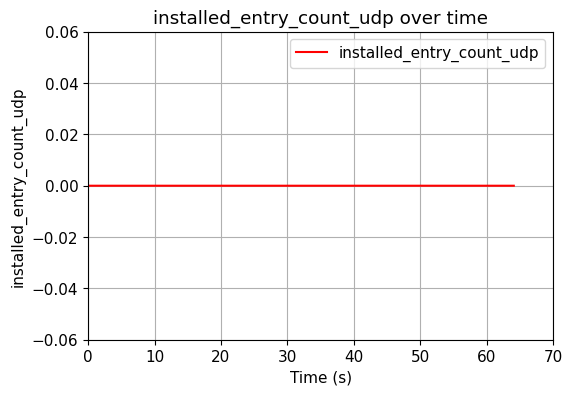

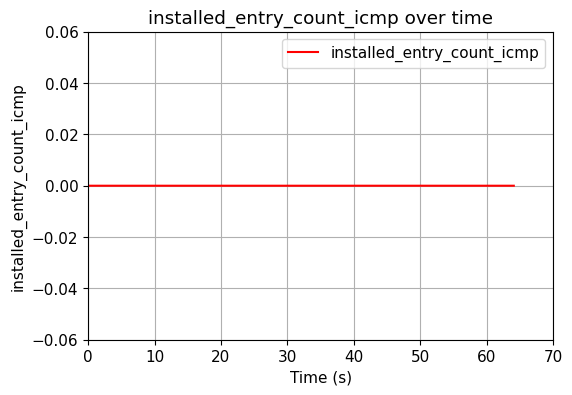

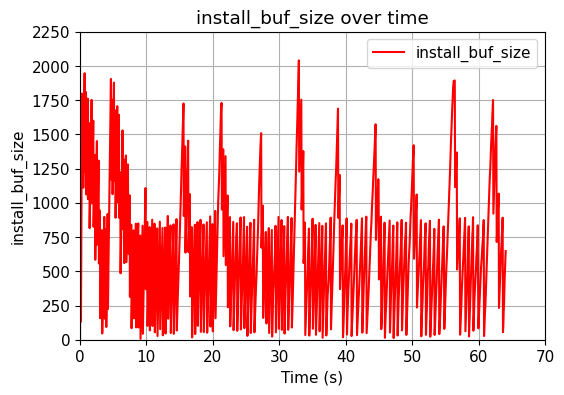

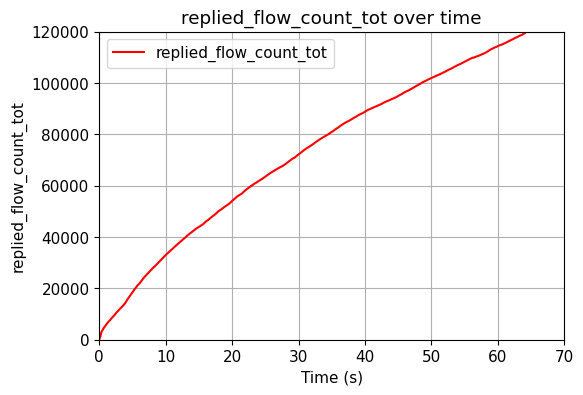

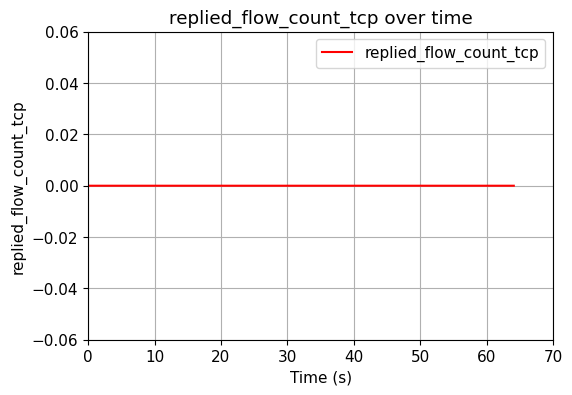

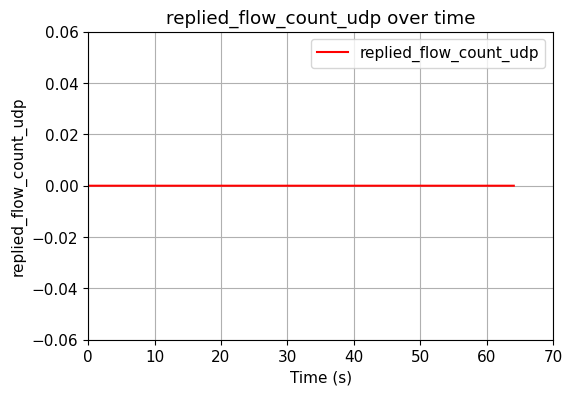

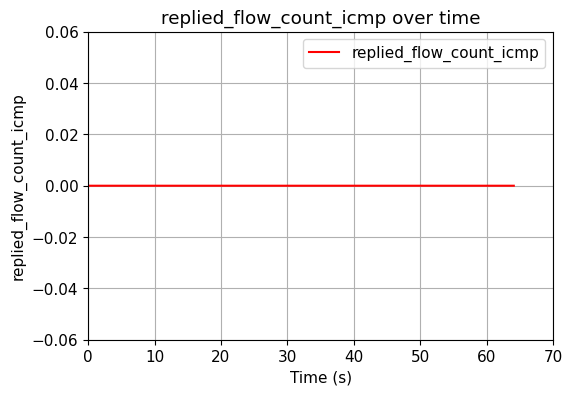

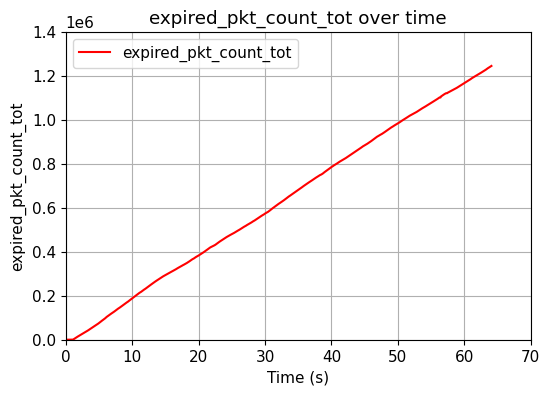

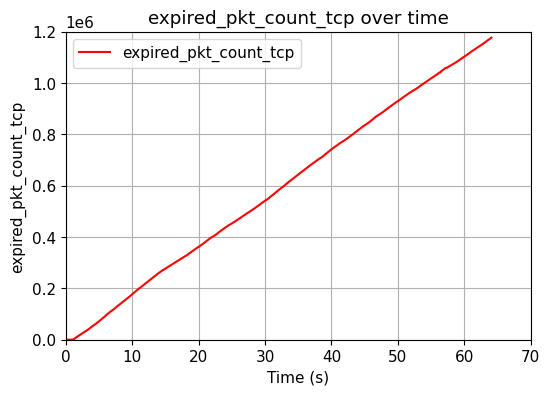

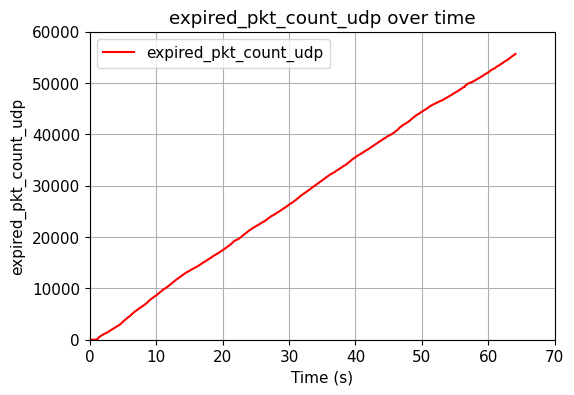

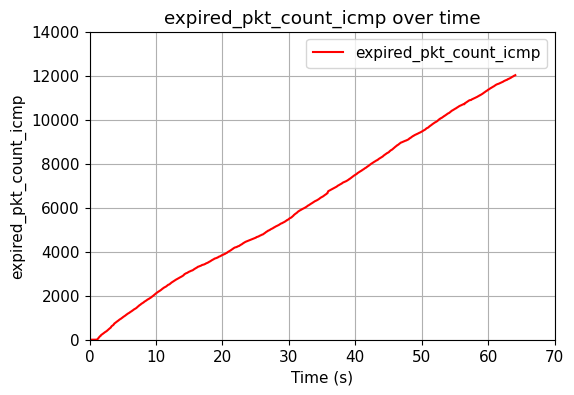

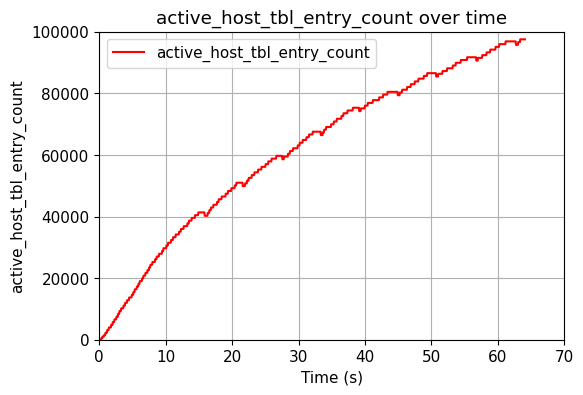

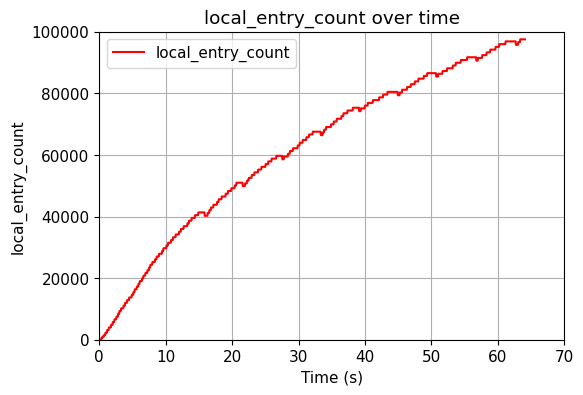

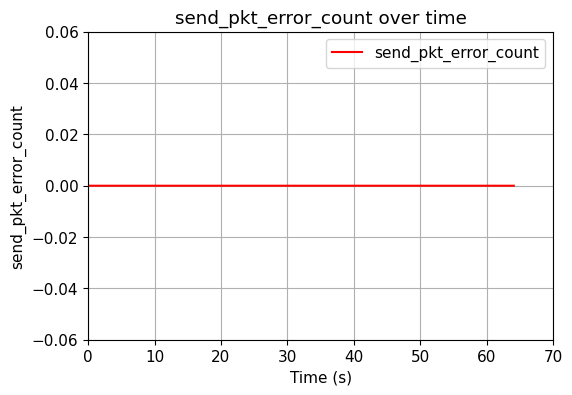

In [80]:
for col in stats_df.columns:
    if col == 'time':
        continue
    plt.figure(figsize=(6, 4))
    plt.plot(stats_df['time'], stats_df[col], label=col)
    plt.xlabel('Time (s)')
    plt.ylabel(col)
    plt.title(f'{col} over time')
    plt.legend()
    plt.grid()
    plt.show()

<Figure size 640x480 with 0 Axes>

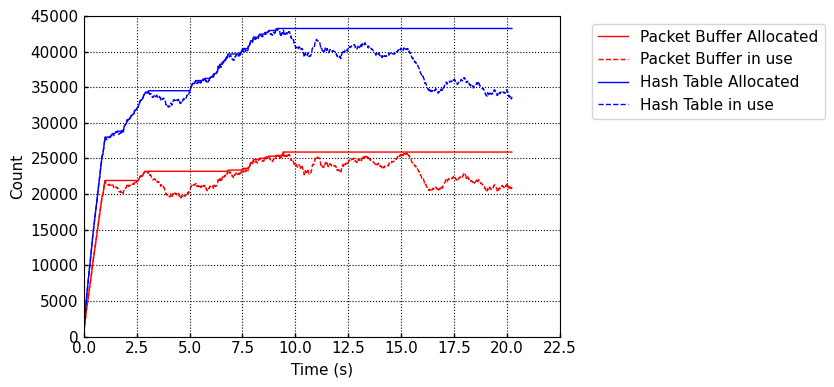

In [10]:
# buffered packet count

fastplot.plot([('Packet Buffer Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, 
              figsize=(6, 4), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0))


<Figure size 640x480 with 0 Axes>

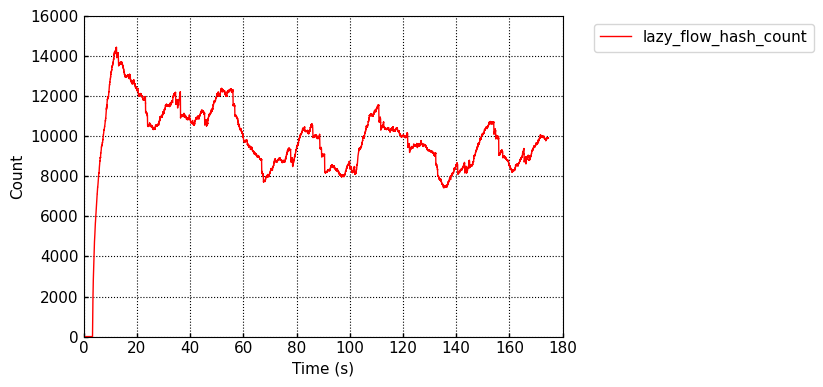

In [121]:
fastplot.plot([('lazy_flow_hash_count', (stats_df['time'], stats_df['lazy_flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, 
              figsize=(6, 4), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              xlabel='Time (s)', 
              ylabel='Count')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0))

<Figure size 640x480 with 0 Axes>

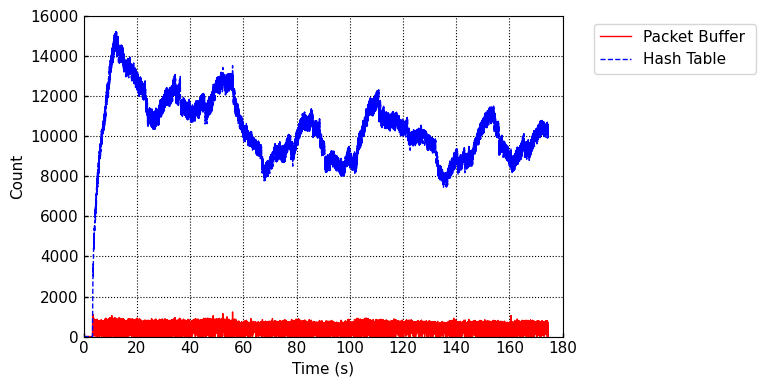

In [122]:
# buffered packet count

fastplot.plot([('Packet Buffer ', (stats_df['time'], stats_df['pkt_buf_count'])),
               ('Hash Table ', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, 
              figsize=(6, 4), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
            #   yscale='log', 
              xlabel='Time (s)', 
              ylabel='Count')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0))


<Figure size 640x480 with 0 Axes>

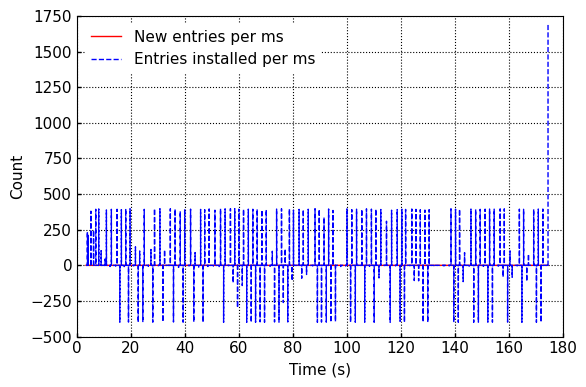

In [123]:
new_entry_cnt_ms = stats_df['replied_flow_count_tot'].diff()[1:]
instal_entry_cnt_ms = stats_df['active_host_tbl_entry_count'].diff()[1:]
# removed_entry_cnt_ms = stats_df['removed_entry_count_tot'].diff()[1:]
time_diff = stats_df['time'].diff()[1:] * 1000
new_entry_cnt_ms = new_entry_cnt_ms / time_diff
instal_entry_cnt_ms = instal_entry_cnt_ms / time_diff

fastplot.plot([('New entries per ms', (stats_df['time'][1:], new_entry_cnt_ms)),
                ('Entries installed per ms', (stats_df['time'][1:], instal_entry_cnt_ms))],
                None,
                mode='line_multi',
                legend=True, legend_loc='best',
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Count')
plt.show()

# Data Plane Resource Usage

## Table Entry Count

<Figure size 640x480 with 0 Axes>

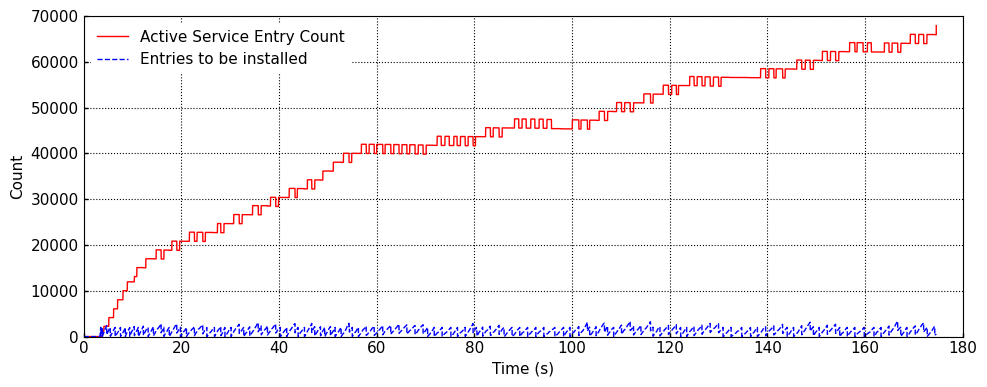

In [124]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count'])),
               ('Entries to be installed', (stats_df['time'], stats_df['install_buf_size']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(10, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')
plt.show()